[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tigarto/tarea-fundamentos/blob/main/entrega_udea.ipynb)

In [2]:
# Importando librerias necesarias
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.impute import SimpleImputer

# Analisis de datos

## 1. Sobre el dataset

Para esta entrega se empleo el **Superstore Dataset** [[link]](https://www.kaggle.com/datasets/vivek468/superstore-dataset-final). Los atributos el dataset, tomados de la descripción de kaggle, se muestran a continuación:
1. **Row ID**: Unique ID for each row.
2. **Order ID**: ID del pedido para cada cliente.
3. **Order Date**: Fecha del pedido del producto.
4. **Ship Date**:  Fecha de envío del producto
5. **Ship Mode**: Modo de envío especificado por el cliente.
6. **Customer ID**: ID del cliente.
7.  **Customer Name**: Nombre del cliente.
8.  **Segment**: Segmento al que pertenece el cliente.
9.  **Country**: País de residencia del cliente
10. **City**: Ciudad de residencia del cliente.
11. **State**: Estado de residencia del cliente.
12. **Postal Code**:  Código postal de cada cliente.
13. **Region**: Región a la que pertenece el cliente.
14. **Product ID**: ID del producto.
15. **Category**: Categoría del producto pedido.
16. **Sub-Category**: Subcategoría del producto pedido.
17. **Product Name**: Nombre del producto.
18. **Sales**: Ventas del producto.
19. **Quantity**: Cantidad del producto.
20. **Discount**: Descuento proporcionado.
21. **Profit**: Profit.

In [54]:
# Carga de los datos al Datafram
path='https://github.com/tigarto/tarea-fundamentos/raw/main/data_market.csv'
df=pd.read_csv(path,encoding='ISO-8859-1',delimiter=';',index_col='Row ID')

## 2. Limpieza y organización de datos

Los siguientes pasos muestran un analisis previo de los datos descargados con el fin de hacer la limpieza y organización de los datos para el analisis.

### 2.1. Tamaño e información resumen

#### 2.2.1. Tamaño

In [55]:
n_fil,n_col = df.shape
print(f'el tamaño del dataframe es de {n_fil} filas y {n_col} columnas')

el tamaño del dataframe es de 9994 filas y 20 columnas


#### 2.2.2. Informacion de las columnas

In [56]:
# Informacion sobre las columnas
df.info()

# Cantidad de columnas por tipo
columnas_numericas = df.select_dtypes(include=['number']).columns
columnas_categoricas = df.select_dtypes(include=['object']).columns
print()
print(f'La cantidad de columnas numericas es {len(columnas_numericas)} y la de categoricas es {len(columnas_categoricas)}')

<class 'pandas.core.frame.DataFrame'>
Index: 9994 entries, 1 to 9994
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9994 non-null   object 
 1   Order Date     9994 non-null   object 
 2   Ship Date      9994 non-null   object 
 3   Ship Mode      9994 non-null   object 
 4   Customer ID    9994 non-null   object 
 5   Customer Name  9994 non-null   object 
 6   Segment        9994 non-null   object 
 7   Country        9994 non-null   object 
 8   City           9994 non-null   object 
 9   State          9994 non-null   object 
 10  Postal Code    9994 non-null   int64  
 11  Region         9994 non-null   object 
 12  Product ID     9994 non-null   object 
 13  Category       9994 non-null   object 
 14  Sub-Category   9994 non-null   object 
 15  Product Name   9994 non-null   object 
 16  Sales          9988 non-null   object 
 17  Quantity       9988 non-null   float64
 18  Discount     

#### 2.2.3. Conversion de tipos

Algunas columnas tiene que cambiar de tipo de datos. A continuación se escribe una función para esto.

In [57]:
def remplazos(df):
  """
  Realiza reemplazos y conversiones de tipos en las columnas 'Profit' y 'Sales' del DataFrame.
  """
  try:
    df['Profit'] = df['Profit'].str.replace('.','')
    df['Profit'] = df['Profit'].astype('float64')
    df['Sales'] = df['Sales'].str.replace('.','')
    df['Sales'] = df['Sales'].astype('float64')
  except Exception as e:
    print("ERROR:", e)
    return df
  return df

In [58]:
df = remplazos(df)
# Se verifican que los cambios hayan sido efectivos
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9994 entries, 1 to 9994
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9994 non-null   object 
 1   Order Date     9994 non-null   object 
 2   Ship Date      9994 non-null   object 
 3   Ship Mode      9994 non-null   object 
 4   Customer ID    9994 non-null   object 
 5   Customer Name  9994 non-null   object 
 6   Segment        9994 non-null   object 
 7   Country        9994 non-null   object 
 8   City           9994 non-null   object 
 9   State          9994 non-null   object 
 10  Postal Code    9994 non-null   int64  
 11  Region         9994 non-null   object 
 12  Product ID     9994 non-null   object 
 13  Category       9994 non-null   object 
 14  Sub-Category   9994 non-null   object 
 15  Product Name   9994 non-null   object 
 16  Sales          9988 non-null   float64
 17  Quantity       9988 non-null   float64
 18  Discount     

#### 2.2.4. Tratamiento de valores nulos

In [65]:
# Valores nulos
nullos=df.isnull().sum().reset_index()
nullos=nullos.rename(columns={'index':'columnas',0:'nullos_c'})
nullos = nullos[nullos.nullos_c > 0]
nullos=nullos.set_index('columnas')
print(f'El numero de columnas con datos nulos es de {nullos.shape[0]} ' +
      f'para un total de {np.array(nullos.nullos_c).sum()} datos nulos en todo el data set\n')
# Dataframe con las estadisticas de datos nulos
nullos

El numero de columnas con datos nulos es de 4 para un total de 24 datos nulos en todo el data set



,nullos_c
columnas,
Sales,6
Quantity,6
Discount,6
Profit,6


In [68]:
nullos=df.isnull().sum().reset_index()
nullos=nullos.rename(columns={'index':'columnas',0:'nullos_c'})
nullos=nullos[nullos.nullos_c>0]
nullos=nullos.set_index('columnas')
print(f'el numero de columnas con datos nullos es de {nullos.shape[0]}\
 para un total de {np.array(nullos.nullos_c).sum()} datos nullos en todo el data set')
nullos

el numero de columnas con datos nullos es de 4 para un total de 24 datos nullos en todo el data set


,nullos_c
columnas,
Sales,6
Quantity,6
Discount,6
Profit,6


In [67]:
# dataframe con las filas que tienen componentes nulos
filtered_df = df[df.isna().any(axis=1)]
# Calculo del porcentaje de valores nulos
nullos['%'] =  round((nullos['nullos_c']/df.shape[0])*100,3)
nullos.loc['total'] = ['=',np.array(nullos['%']).sum()]
nullos

,nullos_c,%
columnas,,
Sales,6,0.06
Quantity,6,0.06
Discount,6,0.06
Profit,6,0.06
total,=,0.24


#### 2.2.5. Reemplazo de valores nulos

Los valores nulos se reemplazan por el promedio

In [70]:
# Reemplazar TSH por la media
mean_imputer = SimpleImputer(strategy='mean')
df.loc[:,['Sales','Quantity','Discount','Profit']] \
        = mean_imputer.fit_transform(df[['Sales','Quantity','Discount','Profit']])

In [71]:
# Se verifica que no hayan valores nulos
df.isnull().values.any()

False

#### 2.2.6. Manejo de valores duplicados

In [72]:
df.index.duplicated().sum()

0

### 2.3. Features para análisis



#### 2.3.1. Nuevas features

Se agregan nueva Features (columnas) para analisis temporal


In [75]:
def tiempo(df):
  """
  Extrae información de la fecha de la columna 'Ship Date' y agrega nuevas columnas para el 'año', 'mes' y 'día' al dataframe.
  """
  df['Ship Date'] = pd.to_datetime(df['Ship Date'])
  df['año']=df['Ship Date'].dt.year
  df['mes']=df['Ship Date'].dt.month
  df['dia']=df['Ship Date'].dt.day
  return df

#### 2.3.2. Seleccion de las features a analizar

En el siguiente dataframe se llevan todos los datos de las columnas con los cuales se realizaran los analisis posteriores.

In [76]:
# se borra pais por que solo tiene un solo country
df__=df.loc[:,['Ship Date','Ship Mode','Customer Name','Segment','City','State','Category','Sub-Category','Quantity','Profit']]
df__=tiempo(df__)
# Se verifica que el dataframe se haya actualizado con las nuevas features
df__.head(3)

,Ship Date,Ship Mode,Customer Name,Segment,City,State,Category,Sub-Category,Quantity,Profit,año,mes,dia
Row ID,,,,,,,,,,,,,
1,2016-11-11,Second Class,Claire Gute,Consumer,Henderson,Kentucky,Furniture,Bookcases,2.0,419136.0,2016,11,11
2,2016-11-11,Second Class,Claire Gute,Consumer,Henderson,Kentucky,Furniture,Chairs,3.0,219582.0,2016,11,11
3,2016-06-16,Second Class,Darrin Van Huff,Corporate,Los Angeles,California,Office Supplies,Labels,2.0,68714.0,2016,6,16


#### 2.3.2. Valores únicos

A continuación se cuentan la cantidad de valores unicos por columna

In [77]:
def unicos(df):
  """
  Devuelve un dataframe con la cantidad de valores unicos por columna
  """
  unicos={i:df[i].nunique()  for i in df.columns }
  return pd.DataFrame(unicos,index=['unicos'])\
                      .T.sort_values(by='unicos',ascending=True)

In [78]:
unicos_= unicos(df__)
# Dataframe con la cantidad de valores unicos por columna
unicos_

,unicos
Segment,3
Category,3
Ship Mode,4
año,5
mes,12
Quantity,15
Sub-Category,17
dia,31
State,49
City,531


> **Conclusion** <br>Al examinar los valores únicos, se puede detectar la
diversidad y la distribución de los datos en cada variable, lo que ayuda a
comprender mejor las relaciones y patrones presentes

## 3. Estadisticas y graficos

### 3.1. Caracteristica `Profit`

#### 3.1.1. Resumen estadistico

In [79]:
promedio_profit = round(np.array(df__['Profit']).mean(),0)
max_profit = round(np.array(df__['Profit']).max(),0)
min_profit = round(np.array(df__['Profit']).min(),0)
desv_= round(np.array(df__['Profit']).std(),0)
Q1 = np.percentile(np.array(df__['Profit']),25)
Q3 = np.percentile(np.array(df__['Profit']),75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Diccionarios con el resumen estadistico
resumen={
    'promedio_profit':promedio_profit,
    'max_profit':max_profit,
    'min_profit':min_profit,
    'desv_':desv_,
    'Q1':Q1,
    'Q3':Q3,
    'limite_inferior':limite_inferior,
    'limite_superior':limite_superior
}

# Dataframe resumen
resumen = pd.DataFrame(resumen,index=['resumen'])
resumen

,promedio_profit,max_profit,min_profit,desv_,Q1,Q3,limite_inferior,limite_superior
resumen,179906.0,67199808.0,-38399904.0,1722850.0,2245.0,151083.0,-221012.0,374340.0


## 4. Agrupación de datos


### 4.1. Caracteristica Segmento

#### 4.1.1. conteo por segmento

In [81]:
# segmento por cliente
segmento = df__.groupby(['Segment'])['Segment'].count()
segmento = segmento.reset_index(name='conteo')
segmento

,Segment,conteo
0,Consumer,5191
1,Corporate,3020
2,Home Office,1783


#### 4.1.2. pivot por segmentos y año

In [82]:
tabla_pivote = pd.pivot_table(
    df__,
    values='Profit',
    index='año',
    columns='Segment',
    aggfunc='sum',
    fill_value=0
)
tabla_pivote

Segment,Consumer,Corporate,Home Office
año,,,
2014,1.938755e+08,9.577946e+07,5.806325e+07
2015,1.208100e+08,1.395866e+08,5.552190e+07
2016,2.439131e+08,1.296206e+08,1.187929e+08
2017,3.478024e+08,1.415228e+08,1.453688e+08
2018,4.757196e+06,2.630155e+06,-5.949800e+04


### 4.2. Ciudad y estado

#### 4.2.1 conteo por ciudad y suma de profit

In [85]:
ciudad = df__.groupby(['City'])['Profit'].sum()
ciudad = ciudad.reset_index(name='sum').sort_values(by='sum',ascending=False).head(21)
ciudad['valores'] = ciudad['sum'].apply(lambda x: '{:,.0f}'.format(x))
conteo = df__.groupby(['City'])['City'].count()
conteo = conteo.reset_index(name='conteo')
df_result = pd.merge(ciudad,conteo,on='City')
df_result = df_result.iloc[:,[0,2,3]]
df_result

,City,valores,conteo
0,New York City,"389,435,030",915
1,Seattle,"219,116,376",428
2,Los Angeles,"178,925,628",747
3,San Francisco,"114,998,620",510
4,Jackson,"62,436,861",82
5,Minneapolis,"58,279,813",23
6,Detroit,"48,016,046",115
7,Newark,"47,684,473",95
8,Springfield,"43,863,451",163
9,San Diego,"41,332,287",170


#### 4.2.2. Profit por estado

In [95]:
estado=df__.groupby(['State'])['Profit'].sum()
estado = estado.reset_index(name='sum').sort_values(by='sum',ascending=False).head(21)
estado['valores'] = estado['sum'].apply(lambda x: '{:,.0f}'.format(x))
estado = estado.iloc[:,[0,2]]
estado

,State,valores
30,New York,"474,152,868"
3,California,"456,584,921"
45,Washington,"243,373,153"
20,Michigan,"116,291,759"
44,Virginia,"113,575,719"
9,Georgia,"87,997,758"
6,Delaware,"87,637,536"
21,Minnesota,"79,633,762"
28,New Jersey,"72,401,896"
15,Kentucky,"67,409,238"


### 4.3. Columnas categoricas

#### 4.3.1. Profit por categoria

In [89]:
categoria = df__.groupby('Category')['Category'].count()
categoria = categoria.reset_index(name='conteo')
categoria_s = df__.groupby('Category')['Profit'].sum()
categoria_s = categoria_s.reset_index(name='suma')
categoria_s['valores'] = categoria_s['suma'].apply(lambda x: '{:,.0f}'.format(x))
categoria_s = pd.merge(categoria,categoria_s,on='Category').sort_values(by='suma',ascending=False)
categoria_s

,Category,conteo,suma,valores
2,Technology,1847,9.627688e+08,"962,768,841"
1,Office Supplies,6026,7.759941e+08,"775,994,074"
0,Furniture,2121,5.922237e+07,"59,222,369"


#### 4.3.2. Profit anual por categoria


In [96]:
tabla_pivote_categoria = pd.pivot_table(
    df__,
    values='Profit',
    index='año',
    columns='Category',
    aggfunc='sum',
    fill_value=0,
)
tabla_pivote_categoria

Category,Furniture,Office Supplies,Technology
año,,,
2014,29904955.0,163310677.0,1.545026e+08
2015,-7857536.0,133231813.0,1.905443e+08
2016,29454013.0,204468545.0,2.584041e+08
2017,3623256.0,272047023.0,3.590238e+08
2018,4097681.0,2936016.0,2.941560e+05


### 4.3. Pedidos a lo largo del tiempo

In [99]:
años_ = df__.groupby('año')['año'].count()
años_ = años_.reset_index(name='conteo')
años_profit = df__.groupby('año')['Profit'].sum()
años_profit = años_profit.reset_index(name='suma')
años_profit['valores'] = años_profit['suma'].apply(lambda x: '{:,.0f}'.format(x))
años_resumen = pd.merge(años_,años_profit,on='año').sort_values(by='año',ascending=False)
años_resumen = años_resumen.iloc[:,[0,1,3]]
años_resumen

,año,conteo,valores
4,2018,42,"7,327,853"
3,2017,3303,"634,694,034"
2,2016,2578,"492,326,639"
1,2015,2131,"315,918,536"
0,2014,1940,"347,718,222"


## 5. Analisis Grafico

### 5.1. Grafica  de tendencia de pedidos

Con esta la idea es tratar de responder a los siguientes interrogantes:
1. [x] ¿Que tipo de tendencia tiene los pedidos en los ultimos años?
2. [x] ¿Se experimentó una desaceleración en las ganancias?

In [100]:
plt.style.use('seaborn-v0_8')

In [102]:
# Informacion tabular
años_= df__.groupby('año')['año'].count()
años_= años_.reset_index(name='conteo')
años_profit=df__.groupby('año')['Profit'].sum()
años_profit=años_profit.reset_index(name='suma')
años_profit['valores'] = años_profit['suma'].apply(lambda x: '{:,.0f}'.format(x))
años_resumen = pd.merge(años_,años_profit,on='año').sort_values(by='año',ascending=False)
años_resumen = años_resumen.iloc[:,[0,1,3]]
años_resumen

,año,conteo,valores
4,2018,42,"7,327,853"
3,2017,3303,"634,694,034"
2,2016,2578,"492,326,639"
1,2015,2131,"315,918,536"
0,2014,1940,"347,718,222"


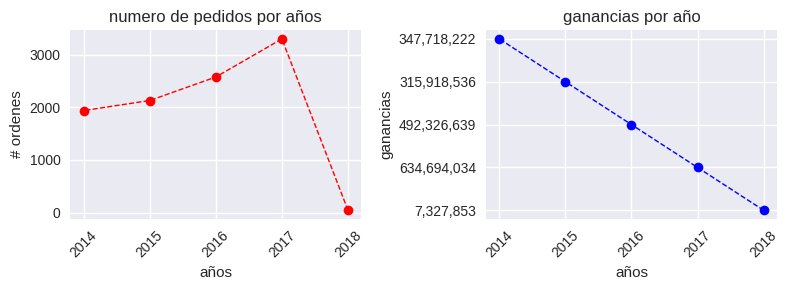

In [105]:
# Grafico

# Se crea una la figura con dos subplots organizados en fila
fig,ax = plt.subplots(1,2, figsize=(8, 3))

# Graficas de cada subplot
ax[0].plot(años_resumen['año'],años_resumen['conteo'],color='red',marker='o',linestyle='--',linewidth=1)
ax[1].plot(años_resumen['año'],años_resumen['valores'],color='b',marker='o',linestyle='--',linewidth=1)

# Parametros grafica eje izquiedo
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_xlabel('años')
ax[0].set_ylabel('# ordenes')
ax[0].set_title('numero de pedidos por años')

# Parametros grafica eje derecho
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel('años')
ax[1].set_ylabel('ganancias')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('ganancias por año')

plt.tight_layout()
plt.show()

### 5.2. Grafica de ganancias por segmento

Trata de responder a las siguientes preguntas:
1. [x] ¿Existen diferencias significativas en el comportamiento de las ganancias entre los tres segmentos?

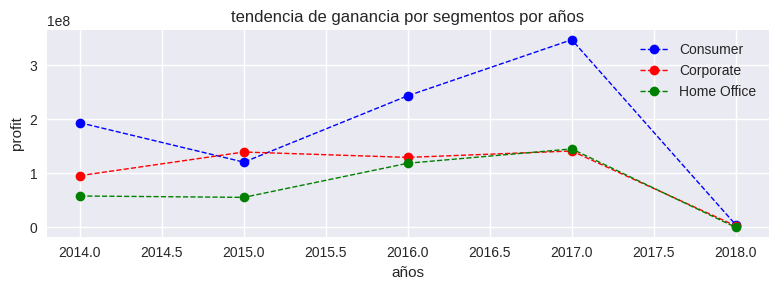

In [106]:
fig , ax = plt.subplots(figsize=(8, 3))

ax.plot(tabla_pivote.index,tabla_pivote['Consumer'],color='b',marker='o',linestyle='--',linewidth=1,label='Consumer')
ax.plot(tabla_pivote.index,tabla_pivote['Corporate'],color='r',marker='o',linestyle='--',linewidth=1,label='Corporate')
ax.plot(tabla_pivote.index,tabla_pivote['Home Office'],color='g',marker='o',linestyle='--',linewidth=1,label='Home Office')
ax.set_title('tendencia de ganancia por segmentos por años')
ax.set_ylabel('profit')
ax.set_xlabel('años')

ax.legend()

plt.tight_layout()
plt.show()

### 5.3. Grafica  de conteo de ordenes y ganancia por categoria y años

Las preguntas a responder son:
1. [x] ¿Cual es la categoria mas rentable?
2. [x] ¿Cual de las categorias registra unos ingresos mas sostenidos?

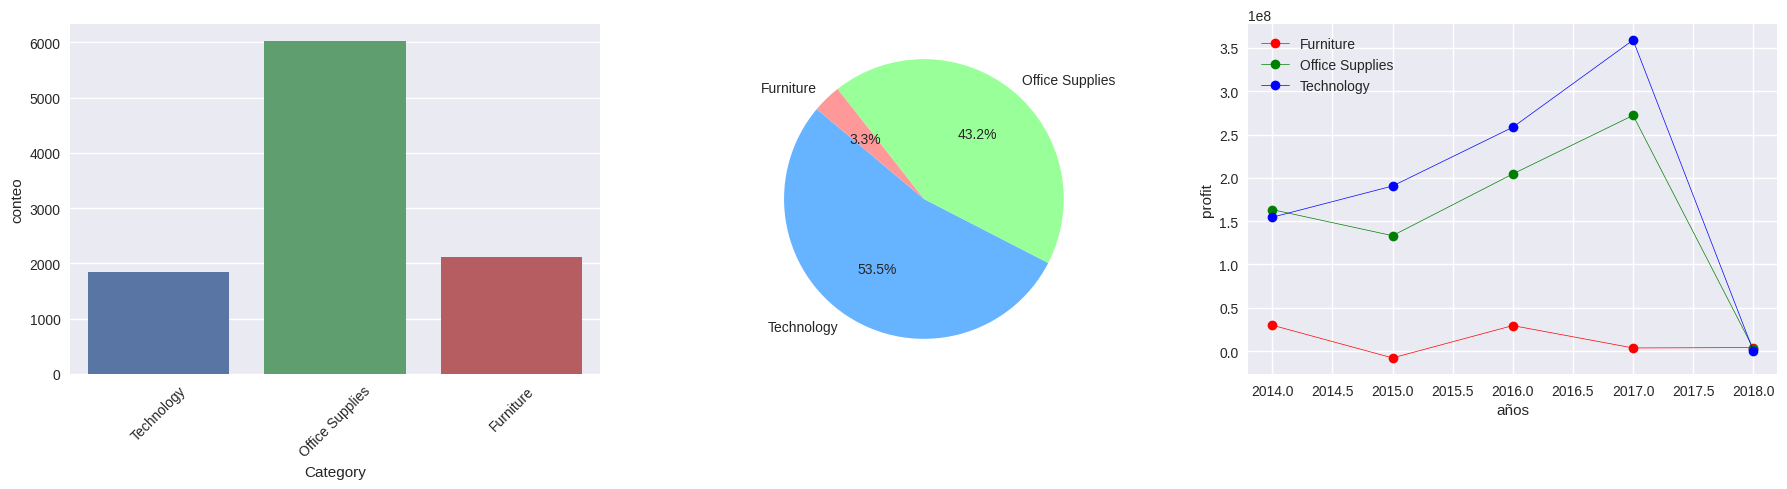

In [108]:
fig , ax =plt.subplots(1,3,figsize=(18, 5))

sns.barplot(x=categoria_s.Category,y=categoria_s.conteo,data=categoria_s,hue='Category',ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)

ax[2].set_xlabel('años')
ax[2].set_ylabel('profit')

ax[2].plot(tabla_pivote_categoria.index,tabla_pivote_categoria['Furniture'],color='r',marker='o',linestyle='-',linewidth=0.5,label='Furniture')
ax[2].plot(tabla_pivote_categoria.index,tabla_pivote_categoria['Office Supplies'],color='g',marker='o',linestyle='-',linewidth=0.5,label='Office Supplies')
ax[2].plot(tabla_pivote_categoria.index,tabla_pivote_categoria['Technology'],color='b',marker='o',linestyle='-',linewidth=0.5,label='Technology')
ax[2].legend()

ax[1].pie(categoria_s['suma'], labels=categoria_s['Category'], autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ff9999','#ffcc99'])

plt.tight_layout()

plt.show()

### 5.3.Grafica de profit por ciudad

Esto y todo lo que falte se lo dejamos al de la foto que lo sabe todo.

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/en/9/93/Buddy_christ.jpg" alt="Yesus" />
</p>

